# Iteration 2


## Introduction

In my final project for "SML 301 - Data Intelligence: Modern Data Science Methods", I built a model to simultaneously count and classify selected animals from the *Wild* dataset.

Diving into the literature long after the course had ended, I discovered a popular technique for enhancing the performance of CNNs. This is the "Squeeze-and-Excitation" Block introduced by [Hu et al.](
https://doi.org/10.48550/arXiv.1709.01507
). As we move through the layers of a CNN, the number of channels grow and deeper features are extracted. When we pass an example into the model, every channel will feed its score into the head of the model to be transformed into an output. The problem occurs when we realize all of these channels are being calculated independently before being passed into the model.

The way Hu et al. solve this problem is by adding a relatively tiny block between two CNN layers. The block *squeezes* the channels by projecting them into much fewer channels (often around a sixteenth of the original number).


## Introduction

In this project we are interested in building a model that predicts the types of animals and the number of animals shown on images in the *Wild* dataset.  We will deviate from the approach used by [Parham et al.](https://ieeexplore.ieee.org/document/8354227) (the paper that we read in Precept 8) and employ a less complicated method inspired by the one used in [*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui instead.


The unique names of the animals of interest are stored in the list `reduced_classes` below.  For each image, our goal is to identify the animals shown on the image and count how many there are.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
_ = !unzip 'drive/My Drive/wild.zip' # "_ =" to suppress output
print('Complete')

Mounted at /content/drive
Complete


In [2]:
reduced_classes = ['giraffe_reticulated','zebra_grevys','turtle_sea',
                   'zebra_plains','giraffe_masai', 'whale_fluke']


In Precept 10 we have created two collections of files to store the NumPy arrays:

* `classify_arr`: with 0 and 1 elements classifying if an animal in `reduced_classes` shows up on the image  
* `count_arr`: with integers counting how many animals showing up on the image for each animal in `reduced_classes`

## Question 1 Data quality check and EDA

### Part a

Provide code and output to verify that you have 5,784 files in each of the *class_annotations* and *count_annotations* folders.

Note: you might see 5,786 files in *class_annotations*.  However, if you check (and please do check this to be sure), you will see that the images ID's shown in *class_annotations* but not in *class_annotations* are `.DS_Store` and `..npy`.  You can ignore these two files.

In [3]:
import os
import numpy as np
import pandas as pd

import cv2 # an image and video processing library
from PIL import Image # Python Imaging Library

import matplotlib.pyplot as plt
%matplotlib inline

**Answers**

In [4]:
count_file_names = os.listdir('wild/count_annotations')
class_file_names = os.listdir('wild/class_annotations')
print(len(count_file_names))
print(len(class_file_names))

5784
5784


### Part b

Print the contents of the following files in the *class_annotations* and *count_annotations* folders by modifying the path to the folders in the cells following the next cell. Please check that your results match the ones provided below.

In [ ]:
# names of the files we will use for inspection
file_names_subset = ['2018_002805.npy', '2018_000974.npy', '2018_000960.npy', '2018_002811.npy', '2018_004290.npy',
                     '2018_002839.npy', '2018_003299.npy', '2018_002187.npy', '2018_000948.npy', '2018_000790.npy',
                     '2018_001483.npy', '2018_000789.npy', '2018_000951.npy', '2018_001497.npy', '2018_003280.npy']

In [ ]:
# Please modify the path below to print `classify_arr` in each file

for file in file_names_subset:
    print(np.load('wild/class_annotations/' + file))

[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]


Your outputs for `classify_arr` should match the following.

```python
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

In [ ]:
# Please modify the path below to print `count_arr` in each file

for file in file_names_subset:
    print(np.load('wild/count_annotations/' + file))

[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]


Your outputs for `count_arr` should match the following.

```python
[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

### Part c

We would like to know how many animals show up in an image in general.

(i.) What is the minimum and maximum of this number?  
(ii.) Please make a histogram for the number of animals in an image.   
(iii.) Is this distribution symmetric or does it have a long left/right tail?  

Hint: You can find sample code online on how  to make a histogram with a list, such as [this](https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data).  Please modify the code to suit your needs.  Also, please use counts for the y-axis.  For all graphs that you make for this report, the plots should have clear labels and be informative.

**Answer**

In [6]:
num_obs = 5784
num_animals = [0] * num_obs
for idx, file in enumerate(count_file_names):
  array = np.load('wild/count_annotations/' + file)
  num_animals[idx] = array.sum()

(i)

In [7]:
print(f'max: {np.max(num_animals)}')
print(f'min: {np.min(num_animals)}')

max: 22.0
min: 1.0


(ii)

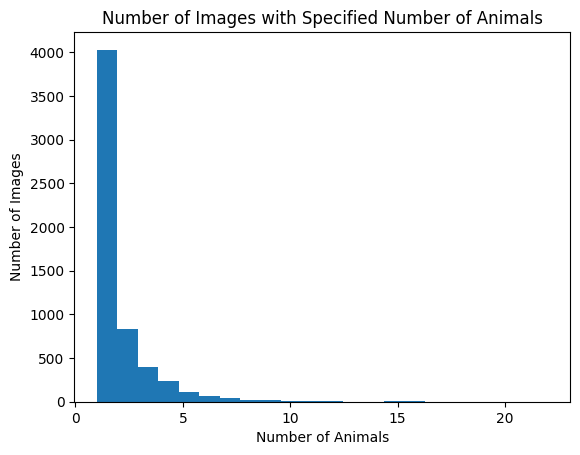

In [8]:
plt.hist(num_animals, bins=22) # min=1 & max=22, so bins=22 shows all
plt.title('Number of Images with Specified Number of Animals')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

(iii) The above histogram has a long right tail. In fact, about 4000 of the 5784 images show just one animal, the minimum number.

### Part d

For each of the six species, create a histogram for the number of animals belonging to that species.  Instead of making 6 histograms, please make one histogram with stacked bins instead (see https://stackoverflow.com/questions/18449602/create-stacked-histogram-from-unequal-length-arrays). This makes it easier to compare the figures across all 6 categories.  Use counts for the y-axis.

Among the 6 animals that we are interested, do any of them show up more frequently than other ones in the images? (You might need to make additional graph(s) that "zoom in" to certain region of the histogram if one single graph does not show all the details.)

**Answer**

In [9]:
num_animals = np.zeros((num_obs, 6))
for idx, file in enumerate(count_file_names):
  array = np.load('wild/count_annotations/' + file)
  for i in range(6):
    num_animals[idx, i] = array[i]

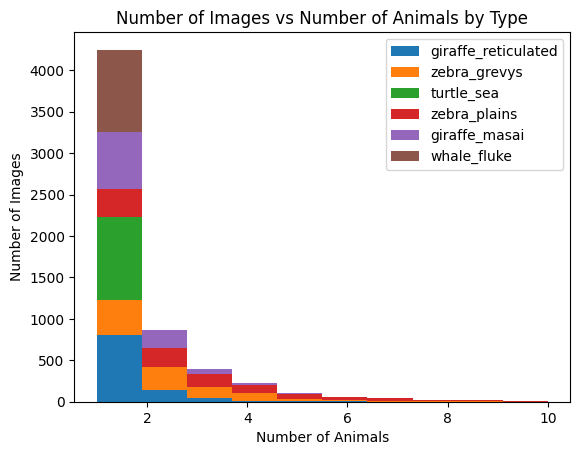

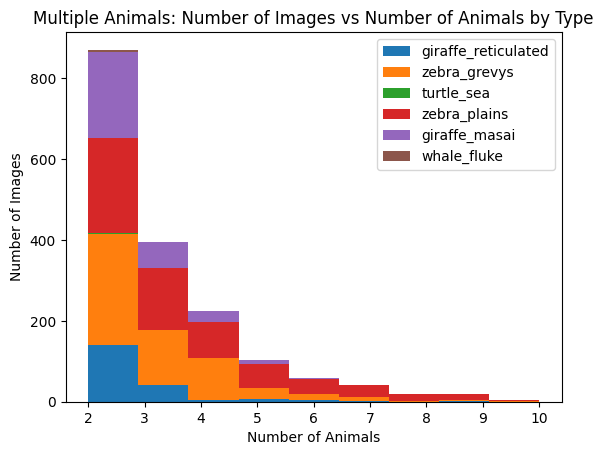

In [10]:
plt.hist(num_animals, bins=10, range=(1,10), stacked=True)
plt.legend(reduced_classes)
plt.title('Number of Images vs Number of Animals by Type')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

plt.hist(num_animals, bins=9, range=(2,10), stacked=True)
plt.legend(reduced_classes)
plt.title('Multiple Animals: Number of Images vs Number of Animals by Type')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

Fluke whales and sea turtles are almost always seen alone. Using the second graph, we see that both types of giraffes appear in groups of up to about 3-4. Likewise, we see both types of zebras appearing in groups of up to 7-9. For each species, there are pictures showing more, but numbers exceeding the upper range we give here are rare.

## Question 2 Build the custom datasets object

Recall that in Ch 8.7 we load the `MNIST` dataset into Python with the `torchvision.datasets` funtion/object and we further divide the dataset into training and validation batches by using the `torch.utils.data.DataLoader` function/object.  For this project, we will need to create the custom version of `torchvision.datasets`, because we are now dealing with a custom dataset that is not built in `PyTorch`.

Please install the `opencv` library with the following code.  It is possible that you might also need to update your `pip` depending on its version.

In [ ]:
# Install opencv for cv2:
!pip install opencv-python

Please read [this tutorial](https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d) on how to define a custom Dataset-class object.  Note that in place of the `glob()` function mentioned in the tutorial, we will use the `read_csv()` function from `pandas` instead.

Here we will define a custom `Datasets` class.  The goal of our custom Dataset-class object is to read the images from the `JPEGImages` folder, resize the images to `img_size`, normalize the pixel values to range (0,1) for each image and then subtract the predefined mean, and divide by the predefined standard deviation. For targets corresponding to the classification and counting tasks, we would like to link the image with corresponding labels from the two .npy files created previously. Lastly, we will use the ID's provided in train.txt, val.txt, test.txt in the *Imagesets/Main* folder to divide the images for training, validation and testing purposes.


The cell below provides the most of the code for creating the custom `Datasets` class. Please

* replace all the directory paths below with paths that that are relevant to your computer system  
* fill in all the parts that labeled with `...`

In [11]:
from PIL import Image # Python Imaging Library
import cv2 # an image and video processing library
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

class ClassifyCountDataset(Dataset):
    def __init__(self, dataset_type, img_size):

        self.img_path = 'wild/JPEGImages/'
        self.classify_path = 'wild/class_annotations/'
        self.count_path = 'wild/count_annotations/'

        # means and sds of images from ImageNet
        train_mean, train_sd = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
        self.transforms = transforms.Compose([
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize(train_mean, train_sd)
        ])
        self.files = pd.read_csv('wild/ImageSets/Main/{}.txt'.format(dataset_type),header=None)[0].tolist()

    def __getitem__(self, index):
        file = self.files[index]
        img = self.transforms(Image.fromarray(cv2.imread(self.img_path+file+'.jpg').astype(np.uint8)))
        classify_target = torch.from_numpy(np.load(self.classify_path+file+'.npy'))
        count_target = torch.from_numpy(np.load(self.count_path+file+'.npy'))

        return img, classify_target, count_target

    def __len__(self):
        return len(self.files)

Please answer the following questions about the `ClassifyCountDataset` class in your report to demonstrate that you understand the concepts explained in the tutorial:

* Describe how `self.files` is calculated.  (Hint: The values that we will assign to `dataset_type` are usually one of these: 'test', 'train', 'trainval', 'val'.)
* Describe the values `self.files` stores when `dataset_type` is set to 'test', and provide a few examples of these values.  
* Describe what steps we take to make `img` (i.e., what the original object is and what steps we take to process the original object) .
* Describe what `classify_target` is and where it is from.

**Answers**

* In the folder wild/ImageSets/Main, there are four text files: test, train, trainval, and val. Inside of these files are strings (e.g., '2018_000118' is inside of test.txt). Then, self.files stores this string and sets dataset_type to the name of the .txt file it is in. For instance, '2018_000118' is stored in self.files and is put into the testing set, or more precisely, dataset_type is set to 'test' (because '2018_000118' is in test.txt).
* The stored values of self.files with dataset_type = 'test' are the strings in wild/ImageSets/Main/test.txt, e.g. '2018_000118' and '2018_002280'.
* Given the (string) value of self.files[-], we take the corresponding image in the JPEGImages folder. This is turned into an array (with 8-bit unsigned integer(uint8) values) and back to image (pixels with 3 uint8 values from 0-255 corresponding to rgb). Then, we then resize, turn it to a tensor with values in [0,1], and normalize according to the mean and std.
* classify_target is the response array we will need for training and testing, the length 6 binary array telling us which species are in the image. Given the (string) value stored in self.files[-], we load the corresponding array in the class_annotations folder.

## Question 3 Model architecture

In this section we will define a convolutional neural network (CNN) that predicts the animals shown on a image, as well as the counts for each animal.  Because our CNN is supposed to produce two different kinds of outputs (animal class identifications and animal counts for each class) our CNN needs to be structured accordingly.


Skim through the Introduction section and read section 3.1 of the paper [*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui.  This should give you a better idea of the structure of the network that we are going to build since our CNN will have an architecture similar to the network in the paper but simpler.  Following similar steps as the ones in the paper, we will build a CNN that has 2 output branches.  Just as the method described in the paper, we will train the upstream layers jointly.  However, instead of using the famous [VGG-16](https://builtin.com/machine-learning/vgg16) network architecture for the upstream layers, we will only borrow the architecture of the first few layers of VGG-16.  This is because VGG-16 has approximately 138 millions of hyperparameters and it will take a long time to train the entire VGG-16.  

The code in the next cell provides you the partial code for building the network for this project.  Please fill in the parts labeled with `...`.  There might be more than one entry needed for each `...`.  You can assume that the input images are of size 128 x 128.

[Batch normalization](https://datahacker.rs/017-pytorch-how-to-apply-batch-normalization-in-pytorch/) is a popular technique used for improving deep neural network performance.  We will use the [torch.nn.BatchNorm2d() function](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to do batch normalization and keep the default values for its input arguments.  Note that batch normalization does not change the shape of its input or output.

Just a reminder: The `nn.Sequential()` function was discussed in Chapter 8.5 of the lecture notes.

I have described the architecture of the network below:

For **block 1**:

* first layer:
    + a convolutional layer with 64 channels with (5 x 5) filters (kernels) with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 64 channels with (5 x 5) filters; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For **block 2**:

* first layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For each of the **branches**

The following two layers are coded with the *self.branches.append()* function

* first layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

Third layer: flatten

The following layers are coded with the *self.outputs.append()* function


* fourth layer:
    + dense layer with 256 neurons; activation function: relu
    + dropout rate: 50%

    
* output layer.




In [12]:
import torch
import torch.nn as nn

In [13]:
class SqueezeExcitation(nn.Module):
  def __init__(self, num_channels, r=16):
    super(SqueezeExcitation, self).__init__()
    self.squeeze = nn.AdaptiveAvgPool2d(1)
    self.excitation = nn.Sequential(
        nn.Linear(num_channels, num_channels//r, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(num_channels//r, num_channels, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    bs, num_channels, _, _ = x.shape
    y = self.squeeze(x).view(bs, num_channels)
    y = self.excitation(y).view(bs, num_channels, 1, 1)
    return x * y.expand_as(x)

class VGG16Counting(nn.Module):
    def __init__(self, num_classes=...):
        super(VGG16Counting, self).__init__()
        # 128 x 128 object
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, 5),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.Conv2d(64, 64, 5),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(2))
        # 60 x 60 object
        self.block2 = nn.Sequential(nn.Conv2d(64, 128, 5),
                                    nn.BatchNorm2d(128), nn.ReLU(),
                                    nn.Conv2d(128, 128, 5),
                                    nn.BatchNorm2d(128), nn.ReLU(),
                                    nn.MaxPool2d(2))
        # 26 x 26 object

        self.se = SqueezeExcitation(128)

        #### create 2 branches below ####

        # initialize two PyTorch lists;
        # ModuleList() is like the native python list container [], but it is for PyTorch.
        self.branches, self.outputs = nn.ModuleList(), nn.ModuleList()
        for _ in range(2):
            # 26 x 26 object
            self.branches.append(nn.Sequential(nn.Conv2d(128, 128, 3, padding=1),
                                               nn.BatchNorm2d(128), nn.ReLU(),
                                               nn.Conv2d(128, 128, 3, padding=1),
                                               nn.BatchNorm2d(128), nn.ReLU(),
                                               nn.MaxPool2d(2)))

            # 13 x 13 object with 128 channels
            self.outputs.append(nn.Sequential(nn.Linear(13 * 13 * 128 * 2, 256),
                                          nn.ReLU(), nn.Dropout(0.2),
                                          nn.Linear(256, 6)))

    def forward(self, x):
      x = self.block1(x)
      x = self.block2(x)
      x = self.se(x)

      x = torch.cat([torch.flatten(branch(x), start_dim=1) for branch in self.branches], 1)

      outputs = [output(x) for output in self.outputs]

      return outputs

## Question 4 Model training

### Part a

In this part of the question we will define the `train()` function for training the model.  Please fill in the parts labeled with `...` for `train()`. A [confusion matrix](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/) is often useful for evaluating the performance of a model.

Besides filling in the places labeled with `...`, modify the `train()` function so that we can later make plots to show that we did not overfit the model (see Part e).

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, mean_squared_error, roc_auc_score

# training loop over batches; forward and backward propagation
def train_batch_loop(model, optimizer, train_dataloader, device, mse, bce):
    for _, (imgs,targets_classify,targets_counts) in enumerate(train_dataloader):
      imgs = imgs.to(device)
      targets_classify = targets_classify.to(device).float()
      targets_counts = targets_counts.to(device).float()

      outputs = model(imgs)
      bce_loss = bce(outputs[0], targets_classify)
      mse_loss = mse(outputs[1], targets_counts)
      loss = bce_loss + mse_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    return

# classwise errors for classification problem
def eval_classify(targets_classify, preds_classify):
    targets_classify_array = targets_classify.cpu().detach().numpy()
    preds_classify_array = preds_classify.cpu().detach().numpy()

    confusion_matrix = multilabel_confusion_matrix(targets_classify_array,
                                                   preds_classify_array)

    classwise_precisions = []
    for i in range(6):
      positives_i = confusion_matrix[i, 1, 1] + confusion_matrix[i, 0, 1]
      precision_i = confusion_matrix[i, 1, 1] / positives_i # TP / (TP + FP)
      classwise_precisions.append(np.round(precision_i, 3))
    print(f'Average precision by class: {classwise_precisions}')

    roc_auc_scores = [roc_auc_score(targets_classify_array[:,i],
                                    preds_classify_array[:,i])
                      for i in range(6)]
    return roc_auc_scores

# classwise errors for counting problem
def eval_count(targets_count, preds_count):
    targets_count_array = targets_count.cpu().detach().numpy()
    preds_count_array = preds_count.cpu().detach().numpy()

    relrmse_classwise = []
    for i in range(6):
      relrmse = np.sqrt(np.mean(np.square(preds_count_array[:,i] -
                                targets_count_array[:,i]) /
                        (preds_count_array[:,i] + 1)))
      relrmse_classwise.append(relrmse)

    avg_relrmse = sum(relrmse_classwise) / len(relrmse_classwise)
    print(f'Mean Relative Root Mean Squared Error: {np.round(avg_relrmse, 4)}')
    return relrmse_classwise

# evaluation loop over batches
def eval_batch_loop(model, validation_dataloader, device):
    total_targets_classify = torch.Tensor().to(device)
    total_preds_classify = torch.Tensor().to(device)
    total_targets_count = torch.Tensor().to(device)
    total_preds_count = torch.Tensor().to(device)
    for _, (imgs, targets_classify, targets_counts) in enumerate(validation_dataloader):
      imgs = imgs.to(device)
      targets_classify = targets_classify.to(device).int()
      targets_counts = targets_counts.to(device).int()
      outputs = model(imgs)

      total_targets_classify = torch.cat((total_targets_classify,targets_classify),dim=0)
      total_preds_classify = torch.cat((total_preds_classify,torch.round(nn.Sigmoid()(outputs[0])).int()),dim=0)

      total_targets_count = torch.cat((total_targets_count,targets_counts),dim=0)
      total_preds_count = torch.cat((total_preds_count,torch.round(nn.ReLU()(outputs[1])).int()),dim=0)

    class_roc_auc = eval_classify(total_targets_classify,
                                  total_preds_classify)
    class_relrmse = eval_count(total_targets_count, total_preds_count)
    return class_roc_auc, class_relrmse

In [15]:
def train(model, optimizer, train_dataloader, val_dataloader, num_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()

    epoch_roc_aucs = np.zeros((num_epochs, 6))
    epoch_relrmses = np.zeros((num_epochs, 6))

    for epoch in range(1, num_epochs + 1):
      print('='*70)
      print(f'Epoch: {epoch}')
      print('='*70)

      # forward & backward propagation in batch loop
      model.train()  # set model to training mode
      train_batch_loop(model, optimizer, train_dataloader, device, mse, bce)

      # save model weights
      if epoch % 5 == 0:
        torch.save(model.state_dict(),
                   f'drive/My Drive/new_se_model Full/epoch_{epoch}.pth')

      # evaluating model at current epoch after training
      model.eval() # set model to evaluation mode
      roc_aucs, relrmses = eval_batch_loop(model, val_dataloader, device)

      epoch_roc_aucs[epoch - 1, :] = roc_aucs
      epoch_relrmses[epoch - 1, :] = relrmses

    return epoch_roc_aucs, epoch_relrmses

### Part b

Note that the loss function is defined to be the sum of two loss functions: `MSELoss()` and `BCEWithLogitsLoss()`.  This is inspired by the loss function used in the paper by Song and Qui.  
Justify why it is reasonable to use the two loss functions `MSELoss()` and `BCEWithLogitsLoss()`.

**Answer**

First of all, we have two different outputs, and these outputs differ in nature. When classifying, we are predicting a binary response, so we have values between 0 and 1. A natural error measurement is then the standard binary cross-entropy. Likewise, when predicting the number of each animal in an image, we are predicting a numerical response. In this case, it makes sense to use the standard MSE.

### Part c

Note that the use of `BCEWithLogitsLoss()` (instead of `nn.CrossEntropyLoss()`) means that we use the sigmoid function (instead of a softmax function) as the activation function for the last layer for the classification branch.  

However, there are 6 neurons in the output layer for the classification branch, one for each class.  For the examples that we have seen in this course, usually when there are more than 2 classes, we use a softmax function on the last layer, and only use the sigmoid function for binary classification.  Explain why the use of the sigmoid function is appropriate here.  (Hint: Suppose that the values (before applying the activation function) for the 6 neurons on the last layer are $z_1, z_2, ..., z_6$.  If we applied the softmax function to these values, the 6 values after the softmax transformation would sum up to be what value? What would be the implied relationship between the classes in this case?  Please include the answers to these questions in your report too.)                                                                                 

**Answer**

If we used softmax, then the values of the 'probabilities' of each species being in the image add to 1. This would be great if each image contained exactly one species, but this is not true for our dataset. Indeed, there are plenty of images with more than one species. The sigmoid function allows the likelihood of a certain species being in the image to be measured independently of the others.

### Part d

Fill in the missing parts below to load the data.

In [ ]:
# Create dataloader
train_dataset = ClassifyCountDataset(dataset_type = 'train', img_size = 128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ClassifyCountDataset(dataset_type = 'val', img_size = 128)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

We initiate the model and define the optimizer below.

In [ ]:
import torch.optim as optim

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initiate model
model = VGG16Counting(num_classes=6).to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Part e

Train the model and make sure that your champion model does not overfit.  Please provide graphs to show that you did not overfit your model.  You do not need to tune any hyperparameters, except for the number of epochs.  

**Hyperparameter Selection**

In [ ]:
roc_aucs_by_epoch, mses_by_epoch = train(model, optimizer, train_dataloader, val_dataloader)
roc_aucs_by_epoch = np.array(roc_aucs_by_epoch)
mses_by_epoch = np.array(mses_by_epoch)
np.save('drive/My Drive/new_se_model/roc_aucs.npy', roc_aucs_by_epoch)
np.save('drive/My Drive/new_se_model/mses.npy', mses_by_epoch)

Epoch: 1
Average precision by class: [0.709, 0.74, 0.983, 0.806, 0.8, 0.922]
Mean Relative Root Mean Squared Error: 0.5529
Epoch: 2
Average precision by class: [0.713, 0.762, 0.983, 0.882, 0.761, 0.967]
Mean Relative Root Mean Squared Error: 0.5161
Epoch: 3
Average precision by class: [0.838, 0.758, 0.994, 0.816, 0.68, 0.953]
Mean Relative Root Mean Squared Error: 0.5093
Epoch: 4
Average precision by class: [0.969, 0.833, 0.983, 0.867, 0.659, 0.858]
Mean Relative Root Mean Squared Error: 0.5436
Epoch: 5
Average precision by class: [0.784, 0.799, 0.964, 0.853, 0.807, 0.983]
Mean Relative Root Mean Squared Error: 0.4854
Epoch: 6
Average precision by class: [0.888, 0.793, 0.979, 1.0, 0.727, 0.984]
Mean Relative Root Mean Squared Error: 0.5034
Epoch: 7
Average precision by class: [0.888, 0.924, 0.933, 0.966, 0.538, 0.984]
Mean Relative Root Mean Squared Error: 0.5242
Epoch: 8
Average precision by class: [0.735, 0.907, 0.995, 0.905, 0.779, 0.973]
Mean Relative Root Mean Squared Error: 0.516

In [ ]:
roc_aucs_by_epoch = np.load('drive/My Drive/new_se_model/roc_aucs.npy')
mses_by_epoch = np.load('drive/My Drive/new_se_model/mses.npy')

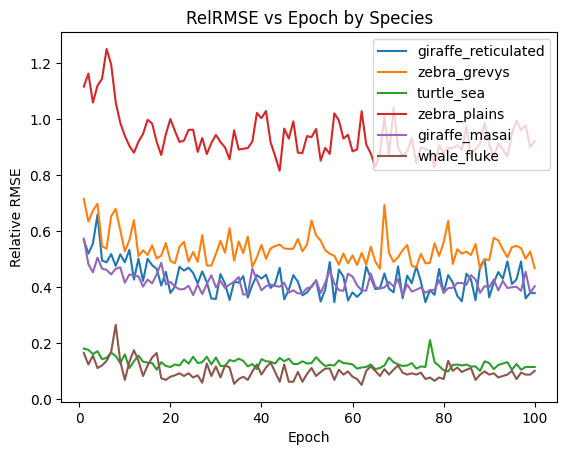

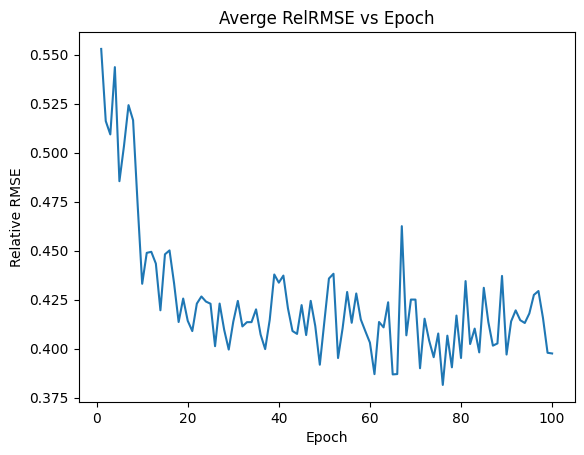

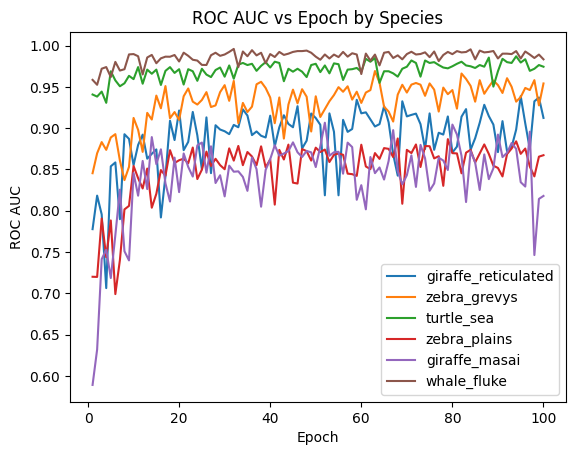

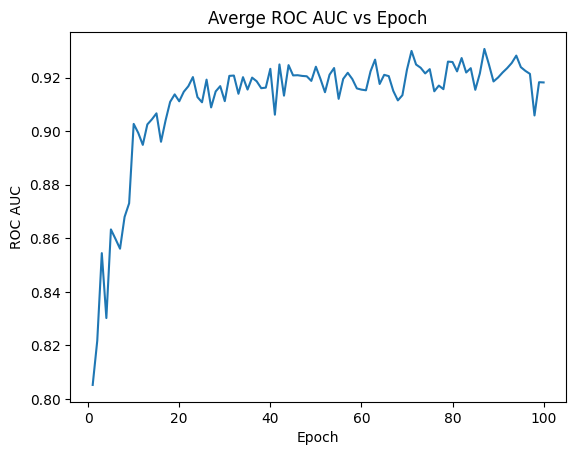

In [ ]:
# relrmses
for i in range(6):
  plt.plot(np.arange(1,101), mses_by_epoch[:,i], label = reduced_classes[i])
plt.legend()
plt.title('RelRMSE vs Epoch by Species')
plt.xlabel('Epoch')
plt.ylabel('Relative RMSE')
plt.show()

# avg relrmse
relrmses = np.mean(mses_by_epoch, axis=1)
plt.plot(np.arange(1,101), relrmses)
plt.title('Averge RelRMSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Relative RMSE')
plt.show()

# roc aucs
for i in range(6):
  plt.plot(np.arange(1,101), roc_aucs_by_epoch[:,i], label = reduced_classes[i])
plt.legend()
plt.title('ROC AUC vs Epoch by Species')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.show()

# avg roc aucs
roc_aucs = np.mean(roc_aucs_by_epoch, axis=1)
plt.plot(np.arange(1,101), roc_aucs)
plt.title('Averge ROC AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.show()

Average RelRMSE drops until about epoch 30 and then flatlines. Average ROC AUC increases quickly until about epoch 20 and then slowly increases until around epoch 80. So again, we chose 80 for the number of epochs to train our champion model.

### Part f

Use your champion model to evaluate on the test set. Report AUC for each animal species for the classification task. Report the relative root mean squared error for the counting task.

**Training & Testing Champion Model**

In [ ]:
# Create dataloader
nontest_dataset = ClassifyCountDataset(dataset_type = 'trainval', img_size = 128)
test_dataset = ClassifyCountDataset(dataset_type = 'test', img_size = 128)

nontest_dataloader = DataLoader(nontest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train full model
champ_epoch = 80
bestmodel = VGG16Counting(num_classes=6).to(device)
optimizer = optim.Adam(bestmodel.parameters(), lr=1e-4)
roc_aucs_by_epoch, mses_by_epoch = train(bestmodel, optimizer,
                                         nontest_dataloader,
                                         test_dataloader,
                                         num_epochs=champ_epoch)
roc_aucs_by_epoch = np.array(roc_aucs_by_epoch)
mses_by_epoch = np.array(mses_by_epoch)
np.save('drive/My Drive/new_se_model Full/roc_aucs.npy', roc_aucs_by_epoch)
np.save('drive/My Drive/new_se_model Full/mses.npy', mses_by_epoch)

Epoch: 1
Average precision by class: [0.859, 0.762, 0.964, 0.843, 0.69, 0.909]
Mean Relative Root Mean Squared Error: 0.6052
Epoch: 2
Average precision by class: [0.864, 0.756, 0.989, 0.866, 0.672, 0.979]
Mean Relative Root Mean Squared Error: 0.5645
Epoch: 3
Average precision by class: [0.878, 0.935, 0.984, 0.504, 0.818, 0.969]
Mean Relative Root Mean Squared Error: 0.5816
Epoch: 4
Average precision by class: [0.826, 0.925, 0.979, 0.794, 0.789, 0.96]
Mean Relative Root Mean Squared Error: 0.5355
Epoch: 5
Average precision by class: [0.963, 0.771, 0.974, 0.785, 0.81, 0.985]
Mean Relative Root Mean Squared Error: 0.4846
Epoch: 6
Average precision by class: [0.846, 0.914, 0.984, 0.798, 0.805, 0.948]
Mean Relative Root Mean Squared Error: 0.4547
Epoch: 7
Average precision by class: [0.87, 0.914, 0.984, 0.9, 0.759, 0.964]
Mean Relative Root Mean Squared Error: 0.5062
Epoch: 8
Average precision by class: [0.876, 0.84, 0.984, 0.819, 0.793, 0.99]
Mean Relative Root Mean Squared Error: 0.4662


In [16]:
roc_aucs_on_test = np.load('drive/My Drive/new_se_model Full/roc_aucs.npy')
relrmses_on_test = np.load('drive/My Drive/new_se_model Full/mses.npy')

In [21]:
# Displaying Test Scores
relrmses_on_test_80 = relrmses_on_test[-1:]
roc_aucs_on_test_80 = roc_aucs_on_test[-1:]

avg_relrmse = np.mean(relrmses_on_test_80)
avg_roc_auc = np.mean(roc_aucs_on_test_80)

final_relrmses = np.append(relrmses_on_test_80, avg_relrmse)
final_roc_aucs = np.append(roc_aucs_on_test_80, avg_roc_auc)

labels = reduced_classes.copy()
labels.append('average')
for i in range(7):
  lbl = labels[i]
  relrmse_i = str(round(final_relrmses[i], 2))
  roc_auc_i = str(round(final_roc_aucs[i], 2))
  string = 'RelRMSE = ' + relrmse_i + '  & ROC AUC = ' + roc_auc_i + '  : ' + lbl
  print(string)

RelRMSE = 0.35  & ROC AUC = 0.95  : giraffe_reticulated
RelRMSE = 0.57  & ROC AUC = 0.95  : zebra_grevys
RelRMSE = 0.1  & ROC AUC = 0.98  : turtle_sea
RelRMSE = 0.81  & ROC AUC = 0.87  : zebra_plains
RelRMSE = 0.51  & ROC AUC = 0.86  : giraffe_masai
RelRMSE = 0.1  & ROC AUC = 0.99  : whale_fluke
RelRMSE = 0.41  & ROC AUC = 0.93  : average
